# MultiModal Document RAG with ColQwen2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/MultiModal_RAG_with_Nvidia_Investor_Slide_Deck.ipynb)

## Introduction

In this notebook we will see how to use Multimodal RAG to chat with the famous paper [Attention is all you need](https://arxiv.org/pdf/1706.03762). The paper has 15 pages with a combination of text, visuals, tables, charts and annotations. The document structure and templates vary from page to page and is quite difficult to RAG over using traditional methods.


## MultiModal RAG Workflow

[ColPali](https://arxiv.org/abs/2407.01449) is a new multimodal retrieval system that seamlessly enables image retrieval. By directly encoding image patches, it eliminates the need for optical character recognition (OCR), or image captioning to extract text from PDFs.

We will use [`byaldi`](https://github.com/AnswerDotAI/byaldi), a library from [AnswerAI](https://www.answer.ai/), that makes it easier to work with an upgraded version of [ColPali](https://huggingface.co/blog/manu/colpali), called [ColQwen2](https://huggingface.co/vidore/colqwen2-v1.0), to embed and retrieve images of our PDF documents.

Retrieved pages will then be passed into a LVM model served via a inference endpoint for it to answer questions.

## ViDoRe

ViDoRe models (Visual Document Retrieval) is an active research area.

Check the [leaderboard](https://huggingface.co/spaces/vidore/vidore-leaderboard) to see how different models compare.

## Model architecture

<img src="images/mmrag_only.png" width="800">

In [4]:
import base64
import os
from pathlib import Path

from byaldi import RAGMultiModalModel
from IPython.display import Image
from openai import OpenAI

In [5]:
openai_api_key = os.environ.get("OPENAI_API_KEY")
hf_read_token = os.environ.get("HF_TOKEN")

### Initialize the ColPali Model

In [3]:
model = RAGMultiModalModel.from_pretrained("vidore/colqwen2-v1.0")

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Lets create a index that will store the embeddings for the page images.

Excuting the cell below takes ~5 mins to index the whole PDF!

In [7]:
index_name = "attention"


In [ ]:
model.index(
    input_path=Path("./PDFs/attention.pdf"),
    index_name=index_name,
    store_collection_with_index=True,  # Stores base64 images along with the vectors
    overwrite=True,
)

In [8]:
# If the document is already indexed, you can load it directly
model = RAGMultiModalModel.from_index(index_path=index_name)

Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using in-memory collection. This means every image is stored in memory.
You might want to rethink this if you have a large collection!
Loaded 15 images from 1 JSON files.


## Let's query our indexed document.

Here the important thing to note is that the query is asking for details that are found on page 15 of the PDF!

In [9]:
# Lets query our index and retrieve the page that has content with the highest similarity to the query

query = "What does the sentence in figure 5 say?"
results = model.search(query, k=5)

print(f"Search results for '{query}':")
for result in results:
    print(f"Doc ID: {result.doc_id}, Page: {result.page_num}, Score: {result.score}")

print("Test completed successfully!")

Search results for 'What does the sentence in figure 5 say?':
Doc ID: 0, Page: 15, Score: 15.1875
Doc ID: 0, Page: 14, Score: 13.75
Doc ID: 0, Page: 13, Score: 12.3125
Doc ID: 0, Page: 11, Score: 10.3125
Doc ID: 0, Page: 7, Score: 10.3125
Test completed successfully!


In [10]:
# Since we stored the collection along with the index we have the base64 images of all PDF pages aswell!
model.search(query, k=1)

[{'doc_id': 0, 'page_num': 15, 'score': 15.1875, 'metadata': {}, 'base64': 'iVBORw0KGgoAAAANSUhEUgAABqQAAAiYCAIAAAA+NVHkAAEAAElEQVR4nOzdeUBUZd//8WvYBURwQTSXFBFRUjE3TM1dc7esLE3NzHrKFlMrl7qzTO/KTG+tXDNTEywXyg3XcAF3xSVE3BAVlH1nYJbfH+e558eDiqZn5sDF+/UXc+Yw34vhzJw5n7kWndlsFgAAAAAAAADKPzutGwAAAAAAAABAHYR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB2AcAAAAAAABIgrAPAAAAAAAAkARhHwAAAAAAACAJwj4AAAAAAABAEoR9AAAAAAAAgCQI+wAAAAAAAABJEPYBAAAAAAAAkiDsAwAAAAAAACRB

In [11]:
returned_page = model.search(query, k=1)[0].base64

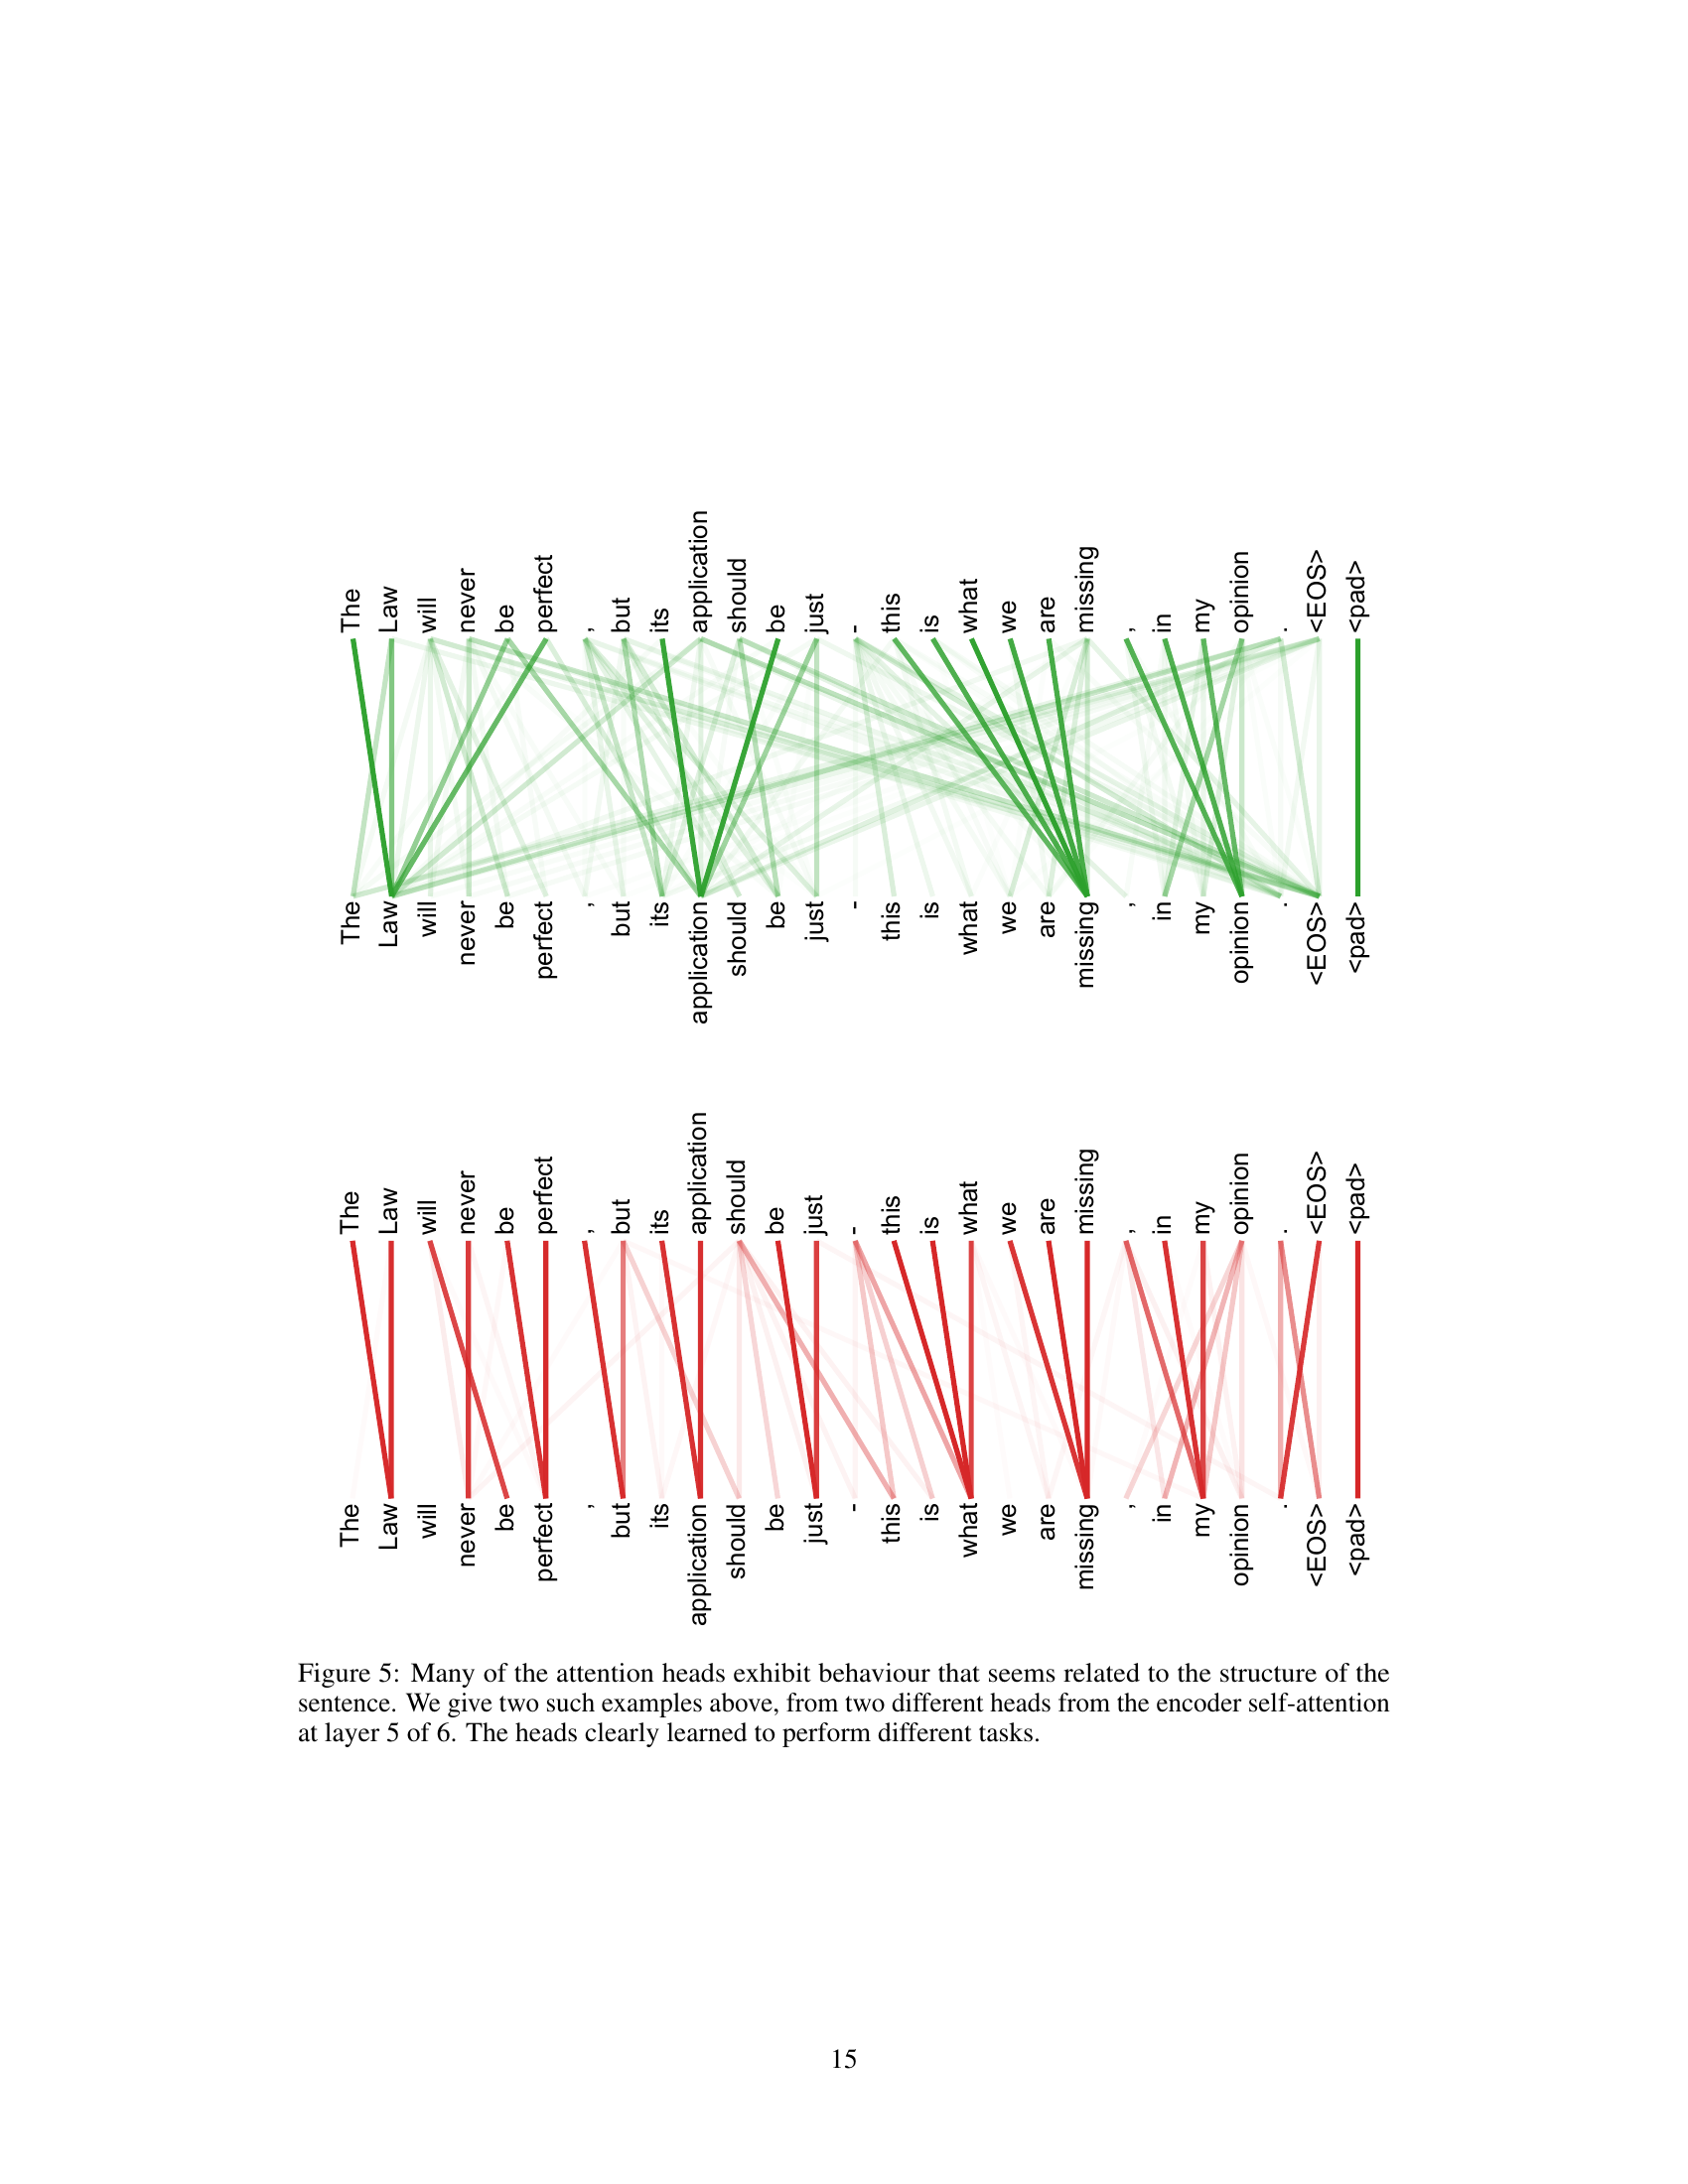

In [12]:
image_bytes = base64.b64decode(returned_page)
filename = "image.jpg"
with open(filename, "wb") as f:
    f.write(image_bytes)


display(Image(filename))

### How does this work? What happens under the hood between the different pages and query token?

The interaction operation between page image patch and query text token representations to score each page of the document is what allows this great retreival performance.

Typically each image is resized and cut into patch sizes of 16x16 pixels. These patches are then embedded into 128 dimensional vectors which are stored and used to perform the MaxSim and late interaction operations between the image and text tokens. ColPali is a multi-vector approach because it produces multiple vectors for each image/query; one vector for each token instead of just one vector for all tokens. 

<img src="images/ColPaliMaxSim-1.png" width="700">

## Lets now pass in the retrieved page to a LVM Model.

This model will read the question: `"What does the sentence in figure 5 say?"` and use the retrieved page to find an answer!


## We'll use OpenAI o1 to query the retrieved document

In [13]:
client = OpenAI(api_key=openai_api_key)

In [14]:
response = client.chat.completions.create(
    model="o1",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": query},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/png;base64,{returned_page}"},
                },
            ],
        }
    ],
)

print(response.choices[0].message.content)

From the figure, the sentence reads:

“The Law will never be perfect, but its application should be just. This is what we are missing, in my opinion.”


Here we can see that the combination of ColQwen2 as a image retriever and a LVM as OpenAI o1 is a powerful duo for multimodal RAG applications specially with PDFs.

Not only was ColQwen2 able to retrieve the correct page that had the right answer on it but then OpanAI o1 was also able to find exactly where on the page this answer was, ignoring all the irrelvant details!

Voila!🎉🎉
